# Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [37]:
import matplotlib.pyplot as plt
import json
import pickle
import os

import jax
import jax.numpy as jnp
import optax
import torch

from basin_volume import *

In [4]:
def make_kl_fn(probs_p, apply_fn, x, l2_reg):
    def kl_fn(a, b):
        params_q = a + b
        logits_q = apply_fn(params_q, x)
        logprobs_q = jax.nn.log_softmax(logits_q)
        kl_term = optax.kl_divergence(logprobs_q, probs_p).mean()
        l2_term = 1/2 * l2_reg * jnp.sum(b**2)
        return kl_term + l2_term
    return kl_fn

def make_kl_fn_params(params_p, apply_fn, x, *, l2_reg):
    logits_p = apply_fn(params_p, x)
    probs_p = jax.nn.softmax(logits_p)
    return make_kl_fn(probs_p, apply_fn, x, l2_reg=l2_reg)

# Model-specific setup

In [5]:
RUNS_DIR = "/mnt/ssd-1/adam/basin-volume/runs"

In [9]:
# load model
step = 65536
model = load_convnext_checkpoint(RUNS_DIR + f"/b16pai_p001/checkpoint-{step}")
model_poisoned = load_convnext_checkpoint(RUNS_DIR + f"/b16pai_p4/checkpoint-{step}")

In [10]:
# load ds

val, _ = load_cifar10_val(size=1024)


In [11]:
# apply_fn

def make_apply_fn(model):
    def apply_fn(params, x):
        params_t = torch.from_dlpack(params).to(torch.float16)
        return jax.dlpack.from_dlpack(get_convnext_logits(params_t, x, model))

    return apply_fn

apply_fn = make_apply_fn(model)
apply_fn_poisoned = make_apply_fn(model_poisoned)


In [12]:
# model to flat JAX params
trained_params_t = torch.nn.utils.parameters_to_vector(model.parameters())
trained_params_t = trained_params_t.to(torch.float32).detach()
trained_params_j = jax.dlpack.from_dlpack(trained_params_t)

poisoned_params_t = torch.nn.utils.parameters_to_vector(model_poisoned.parameters())
poisoned_params_t = poisoned_params_t.to(torch.float32).detach()
poisoned_params_j = jax.dlpack.from_dlpack(poisoned_params_t)


In [13]:
sigma_params = jnp.sqrt(jnp.mean(trained_params_j**2))
sigma_poisoned_params = jnp.sqrt(jnp.mean(poisoned_params_j**2))

In [14]:
kl_fn = make_kl_fn_params(trained_params_j, apply_fn, val, l2_reg=0.)

kl_fn_poisoned = make_kl_fn_params(poisoned_params_j, apply_fn_poisoned, val, l2_reg=0.)

# ADAM munging

In [49]:
def adam_to_vector(model, adam_dict):
    adam_vec = []
    for name, _ in model.named_parameters():
        adam_vec.append(adam_dict[name].detach().flatten())
    return torch.cat(adam_vec)

def load_adam_states(model, RUNS_DIR, run_name, step):
    with open(RUNS_DIR + f"/{run_name}/checkpoint-{step}/optimizer.pt", "rb") as f:
        states = torch.load(f)
    with open("../data/convnext_param_mapping.json", "r") as f:
        param_mapping = json.load(f)
    all_groups_mapping = {int(j): param_mapping[i][j] for i in param_mapping for j in param_mapping[i]}
    adam_param_names = [all_groups_mapping[i] for i in range(len(states['state']))]
    adam1_dict = {adam_param_names[i]: states['state'][i]['exp_avg'] for i in range(len(states['state']))}
    adam2_dict = {adam_param_names[i]: states['state'][i]['exp_avg_sq'] for i in range(len(states['state']))}
    
    adam1 = jax.dlpack.from_dlpack(adam_to_vector(model, adam1_dict))
    adam2 = jax.dlpack.from_dlpack(adam_to_vector(model, adam2_dict))
    return adam1, adam2


In [50]:
adam1, adam2 = load_adam_states(model, RUNS_DIR, "b16pai_p001", 2**16)
adam1_poisoned, adam2_poisoned = load_adam_states(model_poisoned, RUNS_DIR, "b16pai_p4", 2**16)

/tmp/ipykernel_1214063/717518805.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  states = torch.load(f)


# Volume estimates

In [40]:
print(kl_fn(trained_params_j, 0.))
print(kl_fn_poisoned(poisoned_params_j, 0.))
print(kl_fn(trained_params_j, poisoned_params_j - trained_params_j))
print(kl_fn_poisoned(poisoned_params_j, trained_params_j - poisoned_params_j))

4.644824e-09
-1.4921744e-09
1.7786901
5.6403065


In [41]:
RESULTS = {}

In [109]:
trained_params_j.shape[0] / 2**24

0.2019888162612915

In [42]:
cutoff = 1e-2
result_size = 100

RESULTS['normal'] = get_estimates_vectorized_gauss(result_size, 
                                                  batch_size=1,
                                                  sigma=sigma_params,
                                                  fn=kl_fn, 
                                                  params=trained_params_j, 
                                                  cutoff=cutoff,
                                                  tol=1,
                                                  y_tol=10,
                                                  debug=False,
                                                  torch_model=True,
                                                 )



In [43]:

RESULTS['poisoned'] = get_estimates_vectorized_gauss(result_size, 
                                                  batch_size=1,
                                                  sigma=sigma_params,
                                                  fn=kl_fn_poisoned, 
                                                  params=poisoned_params_j, 
                                                  cutoff=cutoff,
                                                  tol=1,
                                                  y_tol=10,
                                                  debug=False,
                                                  torch_model=True,
                                                 )

In [55]:
result_size = 100
cutoff = 1e-2

P_adam = diag_preconditioner(adam2, eps=1e-5, exponent=0.5)
RESULTS['adam'] = get_estimates_vectorized_gauss(result_size, 
                                                  batch_size=1,
                                                  sigma=sigma_params,
                                                  fn=kl_fn, 
                                                  params=trained_params_j, 
                                                  preconditioner=P_adam,
                                                  cutoff=cutoff,
                                                  tol=1,
                                                  y_tol=10,
                                                  debug=False,
                                                  torch_model=True,
                                                 )

P_adam_poisoned = diag_preconditioner(adam2_poisoned, eps=1e-5, exponent=0.5)
RESULTS['adam_poisoned'] = get_estimates_vectorized_gauss(result_size, 
                                                  batch_size=1,
                                                  sigma=sigma_params,
                                                  fn=kl_fn_poisoned, 
                                                  params=poisoned_params_j, 
                                                  preconditioner=P_adam_poisoned,
                                                  cutoff=cutoff,
                                                  tol=1,
                                                  y_tol=10,
                                                  debug=False,
                                                  torch_model=True,
                                                 )


In [58]:
# save results
os.makedirs('results', exist_ok=True)
with open('results/convnext_kl_basins.pkl', 'wb') as f:
    pickle.dump(RESULTS, f)


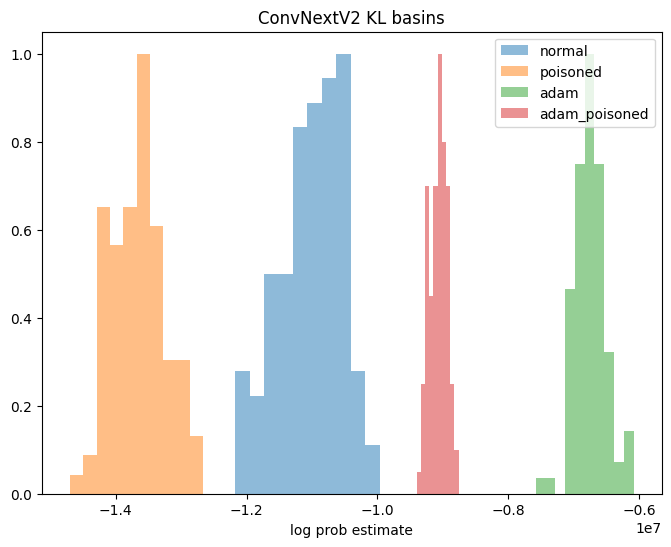

In [57]:
# Create plots directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

def scaled_histogram(values, label, settings):
    nbins = int(jnp.sqrt(len(values)))
    counts, bins = jnp.histogram(values, bins=nbins)
    counts = counts / counts.max()
    plt.stairs(counts, bins, **dict(settings, label=label))

settings = {'alpha': 0.5, 'fill': True}

# Create figure with specific size
plt.figure(figsize=(8, 6))

for label, results in RESULTS.items():
    these_settings = dict(settings, label=label)
    scaled_histogram(results.estimates, label, these_settings)
plt.xlabel("log prob estimate")
plt.legend()
plt.title("ConvNextV2 KL basins")

# Save figure in vector format
plt.savefig('plots/convnext_kl_basins.svg', format='svg', bbox_inches='tight')
plt.show()

## ADAM Preconditioning

In [45]:
# Create separate dictionary for ADAM results
ADAM_RESULTS = {}  # indexed by (eps, exponent) tuples

In [46]:
from tqdm import tqdm

In [51]:
exponent = 0.5
eps_values = logspace(10**-8, 10**-2, 7)
result_size = 10
cutoff = 1e-2

for eps in tqdm(eps_values):
    P_adam = diag_preconditioner(adam2, eps=eps, exponent=float(exponent))
    ADAM_RESULTS[(float(eps), float(exponent))] = get_estimates_vectorized_gauss(
        result_size,
        batch_size=1,
        sigma=sigma_params,
        fn=kl_fn,
        params=trained_params_j,
        preconditioner=P_adam,
        cutoff=cutoff,
        tol=2,
        y_tol=20,
        debug=False,
        torch_model=True,
    )

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [01:07<00:00,  9.63s/it]


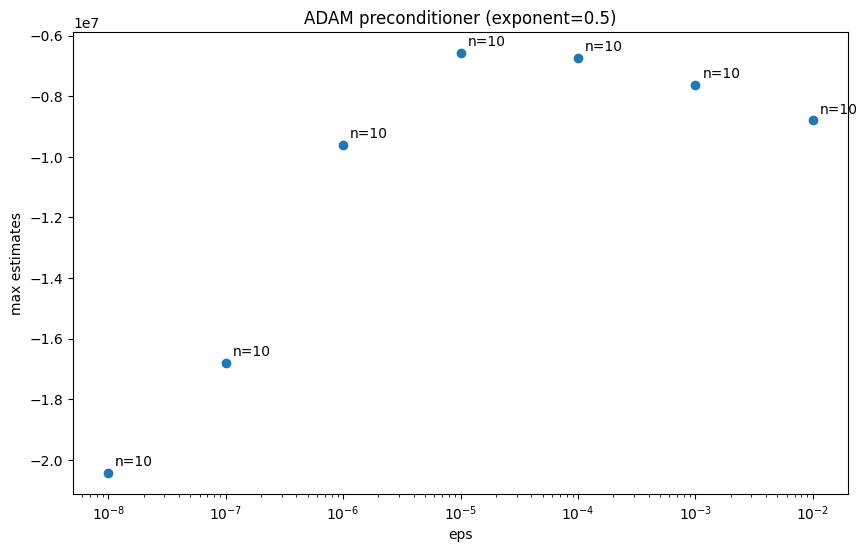

In [52]:
# Plotting code for exponent scan
exponent_keys = [k for k in ADAM_RESULTS.keys() if k[1] == exponent]
epses = [k[0] for k in exponent_keys]
max_estimates = [jnp.max(ADAM_RESULTS[k].estimates)
                 for k in exponent_keys]
plt.figure(figsize=(10, 6))  # Make plot a bit larger for labels
plt.scatter(epses, max_estimates)
# Add labels for each point
for i, (x, y) in enumerate(zip(epses, max_estimates)):
    size = len(ADAM_RESULTS[(x, float(exponent))].estimates)
    plt.annotate(f'n={size}',
                (x, y),
                xytext=(5, 5),  # Small offset from point
                textcoords='offset points')

plt.xscale('log')
plt.xlabel('eps')
plt.ylabel('max estimates')
plt.title(f'ADAM preconditioner (exponent={exponent})')
plt.show()